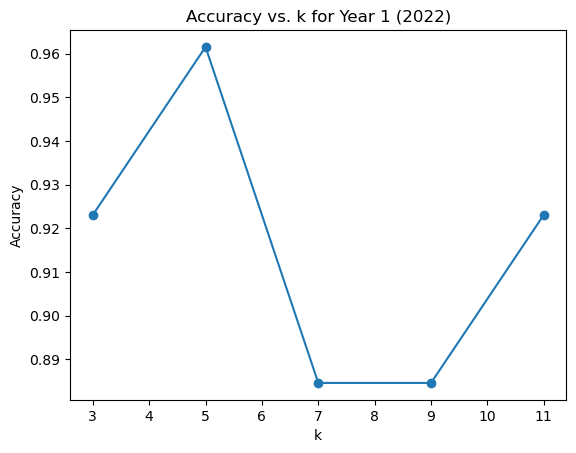

The optimal value of k for year 1 (2022) is 5
Accuracy for year 2 (2023) using k = 5: 0.87
Confusion Matrix for Year 2 (2023):
[[24 0]
 [6 21]]
True Positive Rate (TPR) for Year 2: 0.78
True Negative Rate (TNR) for Year 2: 1.00
Final balance using trading strategy: $80.86
Final balance using buy-and-hold strategy: $102.10
The buy-and-hold strategy resulted in a larger amount at the end of the year.


In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load dataset
data = pd.read_csv('AAL.csv')

# Step 1: Filter data by year
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
year_1_data = data[data['Year'] == 2022]
year_2_data = data[data['Year'] == 2023]

# Step 2: Calculate weekly mean and standard deviation of returns for each week
year_1_weekly_stats = year_1_data.groupby('Week_Number').agg({
    'Return': ['mean', 'std'],
    'Label': 'first'
}).reset_index()
year_1_weekly_stats.columns = ['Week_Number', 'Mean_Return', 'Std_Return', 'Label']

year_2_weekly_stats = year_2_data.groupby('Week_Number').agg({
    'Return': ['mean', 'std'],
    'Label': 'first'
}).reset_index()
year_2_weekly_stats.columns = ['Week_Number', 'Mean_Return', 'Std_Return', 'Label']

# Step 3: Ensure there are 52 weeks in both years
if len(year_1_weekly_stats) != 52 or len(year_2_weekly_stats) != 52:
    print("Warning: The number of weeks is not equal to 52 for either year 2022 or 2023.")
    all_weeks = pd.DataFrame({'Week_Number': range(52)})
    year_1_weekly_stats = pd.merge(all_weeks, year_1_weekly_stats, on='Week_Number', how='left').fillna(0)
    year_2_weekly_stats = pd.merge(all_weeks, year_2_weekly_stats, on='Week_Number', how='left').fillna(0)

# Prepare the feature and target variables for year 1
X_year_1 = year_1_weekly_stats[['Mean_Return', 'Std_Return']]
y_year_1 = year_1_weekly_stats['Label']

# Encode the target labels (Green = 1, Red = 0)
label_encoder = LabelEncoder()
y_year_1 = label_encoder.fit_transform(y_year_1)

# Step 4: Train and test a k-NN classifier using year 1 data
# Split the data into training and testing sets (50/50 split)
X_train, X_test, y_train, y_test = train_test_split(X_year_1, y_year_1, test_size=0.5, random_state=42)

# Finding the optimal k for year 1 data
k_values = [3, 5, 7, 9, 11]
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plot accuracy vs k
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k for Year 1 (2022)')
plt.show()

# Determine the optimal k value
optimal_k = k_values[np.argmax(accuracies)]
print(f"The optimal value of k for year 1 (2022) is {optimal_k}")

# Step 5: Use the optimal k to predict labels for year 2 (2023)
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
knn_optimal.fit(X_year_1, y_year_1)  # Train on the entire year 1 (2022) data
X_year_2 = year_2_weekly_stats[['Mean_Return', 'Std_Return']]
y_year_2 = label_encoder.transform(year_2_weekly_stats['Label'])
y_pred_year_2 = knn_optimal.predict(X_year_2)

# Calculate accuracy for year 2
accuracy_year_2 = accuracy_score(y_year_2, y_pred_year_2)
print(f"Accuracy for year 2 (2023) using k = {optimal_k}: {accuracy_year_2:.2f}")

# Step 6: Manually compute confusion matrix for year 2
TP = ((y_pred_year_2 == 1) & (y_year_2 == 1)).sum()  # True Positives
FP = ((y_pred_year_2 == 1) & (y_year_2 == 0)).sum()  # False Positives
TN = ((y_pred_year_2 == 0) & (y_year_2 == 0)).sum()  # True Negatives
FN = ((y_pred_year_2 == 0) & (y_year_2 == 1)).sum()  # False Negatives

# Print the confusion matrix manually
print(f"Confusion Matrix for Year 2 (2023):")
print(f"[[{TN} {FP}]")
print(f" [{FN} {TP}]]")

# Step 7: Calculate TPR and TNR
TPR = TP / (TP + FN) if (TP + FN) != 0 else 0  # Sensitivity/Recall
TNR = TN / (TN + FP) if (TN + FP) != 0 else 0  # Specificity

print(f"True Positive Rate (TPR) for Year 2: {TPR:.2f}")
print(f"True Negative Rate (TNR) for Year 2: {TNR:.2f}")

# Trading Strategy Based on Predicted Labels
initial_balance = 100.0  # Initial investment
balance = initial_balance
holding = False  # Initially not holding the stock

for i in range(len(y_pred_year_2)):
    label = y_pred_year_2[i]
    weekly_return = year_2_weekly_stats.iloc[i]['Mean_Return']

    if label == 1:  # "Green" -> Buy or hold
        if not holding:  # If not holding, simulate a buy
            holding = True
        balance *= (1 + weekly_return)  # Update balance with weekly return
    else:  # "Red" -> Sell if holding
        if holding:
            holding = False  # Sell

final_balance_strategy = balance
print(f"Final balance using trading strategy: ${final_balance_strategy:.2f}")

# Buy-and-Hold Strategy
buy_and_hold_balance = initial_balance
for i in range(len(year_2_weekly_stats)):
    weekly_return = year_2_weekly_stats.iloc[i]['Mean_Return']
    buy_and_hold_balance *= (1 + weekly_return)

print(f"Final balance using buy-and-hold strategy: ${buy_and_hold_balance:.2f}")

# Comparison
if final_balance_strategy > buy_and_hold_balance:
    print("The trading strategy resulted in a larger amount at the end of the year.")
else:
    print("The buy-and-hold strategy resulted in a larger amount at the end of the year.")



In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load dataset
data = pd.read_csv('AAL.csv')

# Step 1: Filter data by year
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
year_1_data = data[data['Year'] == 2022]
year_2_data = data[data['Year'] == 2023]

# Step 2: Calculate weekly mean and standard deviation of returns for each week
year_1_weekly_stats = year_1_data.groupby('Week_Number').agg({
    'Return': ['mean', 'std'],
    'Label': 'first'
}).reset_index()
year_1_weekly_stats.columns = ['Week_Number', 'Mean_Return', 'Std_Return', 'Label']

year_2_weekly_stats = year_2_data.groupby('Week_Number').agg({
    'Return': ['mean', 'std'],
    'Label': 'first'
}).reset_index()
year_2_weekly_stats.columns = ['Week_Number', 'Mean_Return', 'Std_Return', 'Label']

# Filter out invalid labels (e.g., 0)
year_1_weekly_stats = year_1_weekly_stats[year_1_weekly_stats['Label'].isin(['Red', 'Green'])]
year_2_weekly_stats = year_2_weekly_stats[year_2_weekly_stats['Label'].isin(['Red', 'Green'])]

# Check distribution of labels in the training data
print("Label distribution in training data (2022):")
print(year_1_weekly_stats['Label'].value_counts())

# Step 3: Prepare the feature and target variables for logistic regression
X_year_1 = year_1_weekly_stats[['Mean_Return', 'Std_Return']]
y_year_1 = year_1_weekly_stats['Label']

# Encode the target labels (Green = 1, Red = 0)
label_encoder = LabelEncoder()
y_year_1 = label_encoder.fit_transform(y_year_1)

# Standardize the features
scaler = StandardScaler()
X_year_1_scaled = scaler.fit_transform(X_year_1)

# Step 4: Train the logistic regression model using year 1 data
log_reg = LogisticRegression()
log_reg.fit(X_year_1_scaled, y_year_1)

# Get the coefficients for the logistic regression equation
intercept = log_reg.intercept_[0]
coefficients = log_reg.coef_[0]
print(f"Logistic Regression Equation: y = {intercept:.2f} + ({coefficients[0]:.2f} * Mean_Return) + ({coefficients[1]:.2f} * Std_Return)")

# Step 5: Use the trained model to predict labels for year 2 (2023)
X_year_2 = year_2_weekly_stats[['Mean_Return', 'Std_Return']]
X_year_2_scaled = scaler.transform(X_year_2)  # Apply the same scaling to year 2 data
y_year_2 = label_encoder.transform(year_2_weekly_stats['Label'])
y_pred_year_2 = log_reg.predict(X_year_2_scaled)

# Calculate accuracy for year 2
accuracy_year_2 = accuracy_score(y_year_2, y_pred_year_2)
print(f"Accuracy for year 2 (2023): {accuracy_year_2:.2f}")

# Step 6: Manually compute confusion matrix for year 2
TP = ((y_pred_year_2 == 1) & (y_year_2 == 1)).sum()  # True Positives
FP = ((y_pred_year_2 == 1) & (y_year_2 == 0)).sum()  # False Positives
TN = ((y_pred_year_2 == 0) & (y_year_2 == 0)).sum()  # True Negatives
FN = ((y_pred_year_2 == 0) & (y_year_2 == 1)).sum()  # False Negatives

# Print the confusion matrix manually
print(f"Confusion Matrix for Year 2 (2023):")
print(f"[[{TN} {FP}]")
print(f" [{FN} {TP}]]")

# Step 7: Calculate TPR and TNR
TPR = TP / (TP + FN) if (TP + FN) != 0 else 0  # Sensitivity/Recall
TNR = TN / (TN + FP) if (TN + FP) != 0 else 0  # Specificity

print(f"True Positive Rate (TPR) for Year 2: {TPR:.2f}")
print(f"True Negative Rate (TNR) for Year 2: {TNR:.2f}")

# Implementing the trading strategy based on predicted labels
initial_balance = 100.0  # Starting with $100
balance_trading = initial_balance
holding = False

for i, label in enumerate(y_pred_year_2):
    weekly_return = year_2_weekly_stats.iloc[i]['Mean_Return']
    if label == 1:  # Green - Buy or Hold
        if not holding:
            # Assume buying at the beginning of the week
            balance_trading += balance_trading * weekly_return
            holding = True
    elif label == 0 and holding:  # Red - Sell
        # Assume selling at the end of the week
        holding = False

# Calculate the final balance for the trading strategy
if holding:
    # Sell at the end of the year if still holding
    holding = False

# Buy-and-hold strategy (assume buying at the start and holding to the end)
start_price = year_2_data.iloc[0]['Close']
end_price = year_2_data.iloc[-1]['Close']
balance_buy_and_hold = initial_balance * (end_price / start_price)

# Compare the results
print(f"Final Balance using Trading Strategy: ${balance_trading:.2f}")
print(f"Final Balance using Buy-and-Hold Strategy: ${balance_buy_and_hold:.2f}")

# Determine which strategy performed better
if balance_trading > balance_buy_and_hold:
    print("The Trading Strategy results in a larger amount at the end of the year.")
else:
    print("The Buy-and-Hold Strategy results in a larger amount at the end of the year.")


Label distribution in training data (2022):
Label
Red      27
Green    24
Name: count, dtype: int64
Logistic Regression Equation: y = 0.23 + (-2.96 * Mean_Return) + (0.30 * Std_Return)
Accuracy for year 2 (2023): 0.96
Confusion Matrix for Year 2 (2023):
[[24 0]
 [2 25]]
True Positive Rate (TPR) for Year 2: 0.93
True Negative Rate (TNR) for Year 2: 1.00
Final Balance using Trading Strategy: $89.99
Final Balance using Buy-and-Hold Strategy: $107.85
The Buy-and-Hold Strategy results in a larger amount at the end of the year.
